# ABNORMALITY DETECTION

## Data Loading

### Subtask:
Load the `events.csv` data into a pandas DataFrame.

**Reasoning**:
Load the `events.csv` data into a pandas DataFrame for further processing and analysis.

In [ ]:
import pandas as pd

# Load the events data
events_df = pd.read_csv('/content/drive/MyDrive/data/TMP/events.csv')

# Display the first few rows to confirm
print("First few rows of events_df:")
display(events_df.head())

# Check the shape of the dataset
print("\nShape of events_df:")
display(events_df.shape)

First few rows of events_df:


,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN



Shape of events_df:


(2756101, 5)

## Feature Engineering

### Subtask:
Create features to characterize user behavior from the `events_df`.

**Reasoning**:
Generate features such as the number of events per user, event types, and session duration to characterize user behavior.

In [ ]:
# Convert timestamp to datetime
events_df['timestamp'] = pd.to_datetime(events_df['timestamp'], unit='ms')

# Sort events by visitorid and timestamp
events_df = events_df.sort_values(by=['visitorid', 'timestamp'])

# Sample 40% of the data to speed up processing
events_df_sampled = events_df.sample(frac=0.4, random_state=42)

# Calculate time difference between consecutive events for each visitor in the sampled data
events_df_sampled['time_diff'] = events_df_sampled.groupby('visitorid')['timestamp'].diff().dt.total_seconds().fillna(0)


# Create features for each visitor using the sampled data
user_features = events_df_sampled.groupby('visitorid').agg(
    num_events=('event', 'count'),
    unique_events=('event', lambda x: x.nunique()),
    time_spent=('time_diff', 'sum'),
    avg_time_between_events=('time_diff', 'mean'),
    max_time_between_events=('time_diff', 'max'),
    num_items_viewed=('itemid', lambda x: x[events_df_sampled.loc[x.index, 'event'] == 'view'].nunique()),
    num_adds_to_cart=('itemid', lambda x: x[events_df_sampled.loc[x.index, 'event'] == 'addtocart'].nunique()),
    num_transactions=('itemid', lambda x: x[events_df_sampled.loc[x.index, 'event'] == 'transaction'].nunique())
).reset_index()

# Display the first few rows and info of the user features DataFrame
print("First few rows of user_features:")
display(user_features.head())
print("\nInfo for user_features DataFrame:")
user_features.info()

First few rows of user_features:


,visitorid,num_events,unique_events,time_spent,avg_time_between_events,max_time_between_events,num_items_viewed,num_adds_to_cart,num_transactions
0,0,2,1,-170.152,-85.076000,0.00,2,0,0
1,2,3,1,-1430.585,-476.861667,213.47,2,0,0
2,3,1,1,0.000,0.000000,0.00,1,0,0
3,6,1,1,0.000,0.000000,0.00,1,0,0
4,7,1,1,0.000,0.000000,0.00,1,0,0



Info for user_features DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707122 entries, 0 to 707121
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   visitorid                707122 non-null  int64  
 1   num_events               707122 non-null  int64  
 2   unique_events            707122 non-null  int64  
 3   time_spent               707122 non-null  float64
 4   avg_time_between_events  707122 non-null  float64
 5   max_time_between_events  707122 non-null  float64
 6   num_items_viewed         707122 non-null  int64  
 7   num_adds_to_cart         707122 non-null  int64  
 8   num_transactions         707122 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 48.6 MB


## Abnormal User Detection Model

### Subtask:
Choose an appropriate model for anomaly detection.

**Reasoning**:
Select an Isolation Forest model for detecting abnormal users based on the engineered features.

In [ ]:
from sklearn.ensemble import IsolationForest

# Initialize the Isolation Forest model
# n_estimators: the number of base estimators in the ensemble
# contamination: the proportion of outliers in the data set. 'auto' tries to decide by itself.
# random_state: for reproducibility
model = IsolationForest(n_estimators=100, contamination='auto', random_state=42, n_jobs=-1)

## Model Training

### Subtask:
Train the anomaly detection model on the engineered features.

**Reasoning**:
Train the Isolation Forest model using the `user_features` DataFrame.

In [ ]:
# Drop the 'visitorid' column as it's not a feature for the model
user_features_for_model = user_features.drop('visitorid', axis=1)

# Handle potential infinite values in the features (can arise from division by zero or other operations)
# Replace inf with a large number or NaN, then handle NaN
user_features_for_model.replace([float('inf'), float('-inf')], float('nan'), inplace=True)
user_features_for_model.fillna(user_features_for_model.mean(), inplace=True) # Or another imputation strategy

# Train the Isolation Forest model
model.fit(user_features_for_model)

IsolationForest(n_jobs=-1, random_state=42)

## Abnormal User Identification

### Subtask:
Use the trained model to identify users who are classified as abnormal or outliers.

**Reasoning**:
Predict anomaly scores and labels for the users based on the trained Isolation Forest model.

In [ ]:
# Predict anomaly scores (-1 for outliers, 1 for inliers)
anomaly_labels = model.predict(user_features_for_model)

# Add the anomaly labels to the user_features DataFrame
user_features['anomaly_label'] = anomaly_labels

# Identify abnormal users (where anomaly_label is -1)
abnormal_users = user_features[user_features['anomaly_label'] == -1]

print("\nFirst few rows of abnormal users:")
display(abnormal_users.head())
print("\nNumber of abnormal users found:", len(abnormal_users))


First few rows of abnormal users:


,visitorid,num_events,unique_events,time_spent,avg_time_between_events,max_time_between_events,num_items_viewed,num_adds_to_cart,num_transactions,anomaly_label
18,32,2,1,-681838.904,-340919.452000,0.000,2,0,0,-1
30,54,5,1,83588.992,16717.798400,83495.907,4,0,0,-1
35,64,2,1,700024.076,350012.038000,700024.076,2,0,0,-1
41,75,9,1,113240.851,12582.316778,1463481.077,1,0,0,-1
53,97,3,1,811106.588,270368.862667,811283.826,2,0,0,-1



Number of abnormal users found: 54064


## Metric Creation

### Subtask:
Define a metric that helps to evaluate quality of the model.

**Reasoning**:
Since we don't have true labels for abnormal users, we can analyze the characteristics of the identified abnormal users to evaluate the model's quality. We can look at the distribution of features for abnormal vs. normal users.


Description of features for abnormal users:


,visitorid,num_events,unique_events,time_spent,avg_time_between_events,max_time_between_events,num_items_viewed,num_adds_to_cart,num_transactions,anomaly_label
count,5.406400e+04,54064.000000,54064.000000,5.406400e+04,5.406400e+04,5.406400e+04,54064.000000,54064.000000,54064.000000,54064.0
mean,7.049579e+05,5.582125,1.328777,1.157891e+04,3.120848e+03,1.205037e+06,3.737663,0.484907,0.150063,-1.0
std,4.064023e+05,25.211672,0.555504,2.447290e+06,1.015245e+06,2.104363e+06,17.527457,2.173638,1.645650,0.0
min,3.200000e+01,1.000000,1.000000,-1.165060e+07,-5.825301e+06,0.000000e+00,0.000000,0.000000,0.000000,-1.0
25%,3.529490e+05,2.000000,1.000000,-9.668531e+04,-1.623124e+04,0.000000e+00,1.000000,0.000000,0.000000,-1.0
50%,7.065010e+05,3.000000,1.000000,0.000000e+00,0.000000e+00,6.887268e+04,2.000000,0.000000,0.000000,-1.0
75%,1.057642e+06,5.000000,2.000000,3.529318e+05,8.290068e+04,1.467797e+06,4.000000,1.000000,0.000000,-1.0
max,1.407573e+06,3125.000000,3.000000,1.170437e+07,5.852186e+06,1.180200e+07,2013.000000,267.000000,216.000000,-1.0



Description of features for normal users:


,visitorid,num_events,unique_events,time_spent,avg_time_between_events,max_time_between_events,num_items_viewed,num_adds_to_cart,num_transactions,anomaly_label
count,6.530580e+05,653058.000000,653058.0,653058.000000,653058.000000,6.530580e+05,653058.000000,653058.0,653058.000000,653058.0
mean,7.043105e+05,1.225998,1.0,-1567.267492,-695.063277,2.842580e+03,1.138495,0.0,0.001133,1.0
std,4.064036e+05,0.631712,0.0,32704.999835,15124.028273,3.352657e+04,0.457396,0.0,0.034274,0.0
min,0.000000e+00,1.000000,1.0,-712337.929000,-306815.592000,0.000000e+00,0.000000,0.0,0.000000,1.0
25%,3.523295e+05,1.000000,1.0,0.000000,0.000000,0.000000e+00,1.000000,0.0,0.000000,1.0
50%,7.046105e+05,1.000000,1.0,0.000000,0.000000,0.000000e+00,1.000000,0.0,0.000000,1.0
75%,1.056368e+06,1.000000,1.0,0.000000,0.000000,0.000000e+00,1.000000,0.0,0.000000,1.0
max,1.407576e+06,17.000000,1.0,407232.718000,156154.212000,2.445994e+06,5.000000,0.0,2.000000,1.0


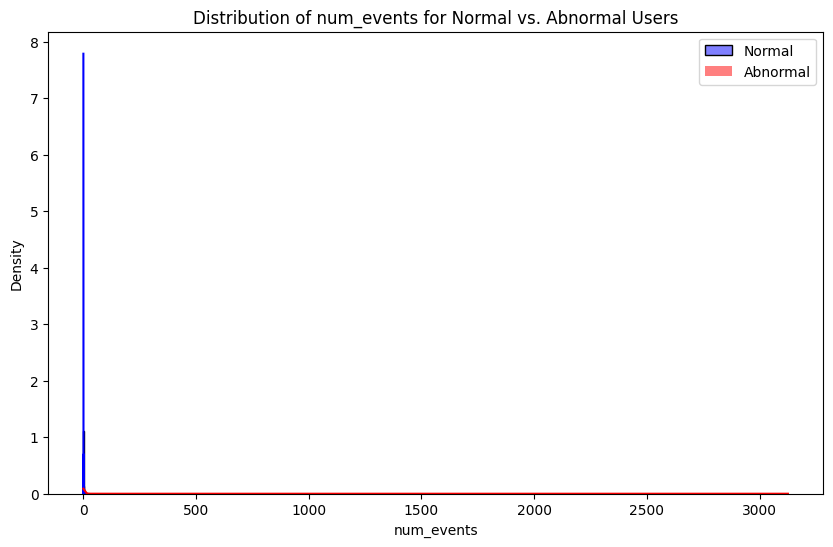

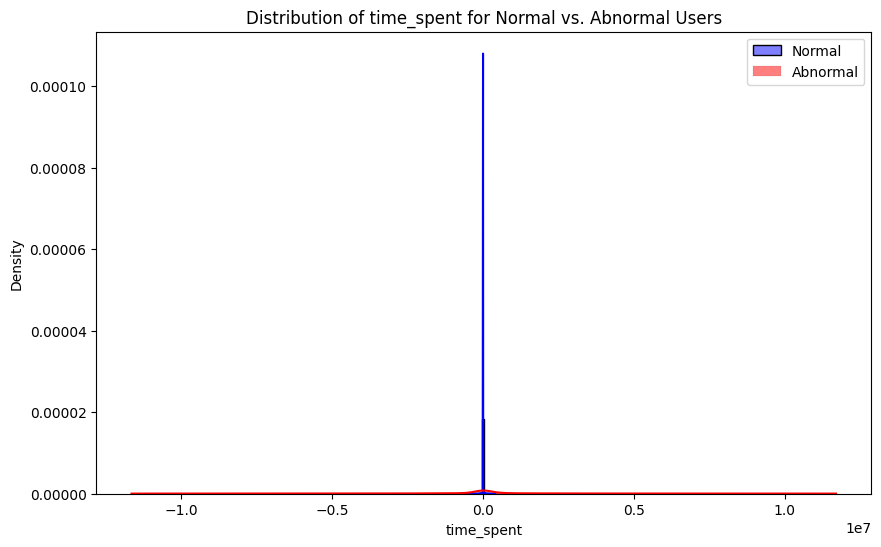

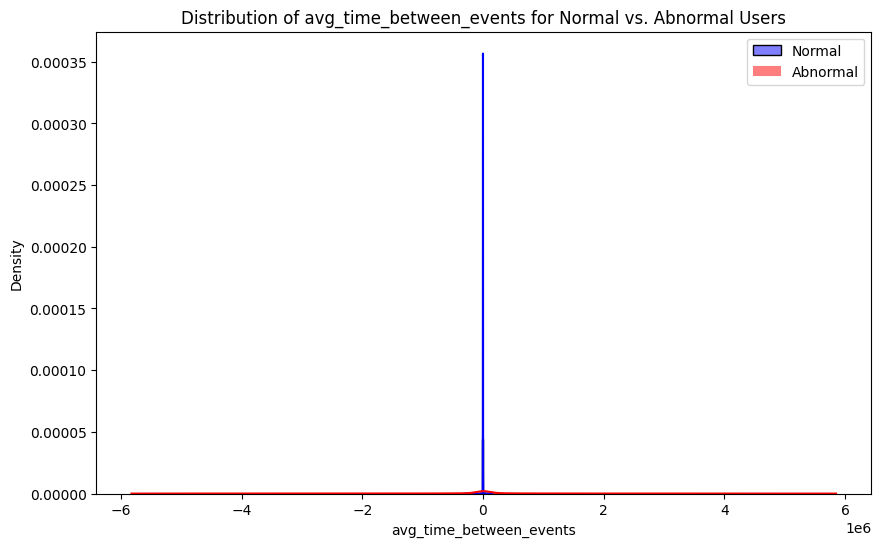

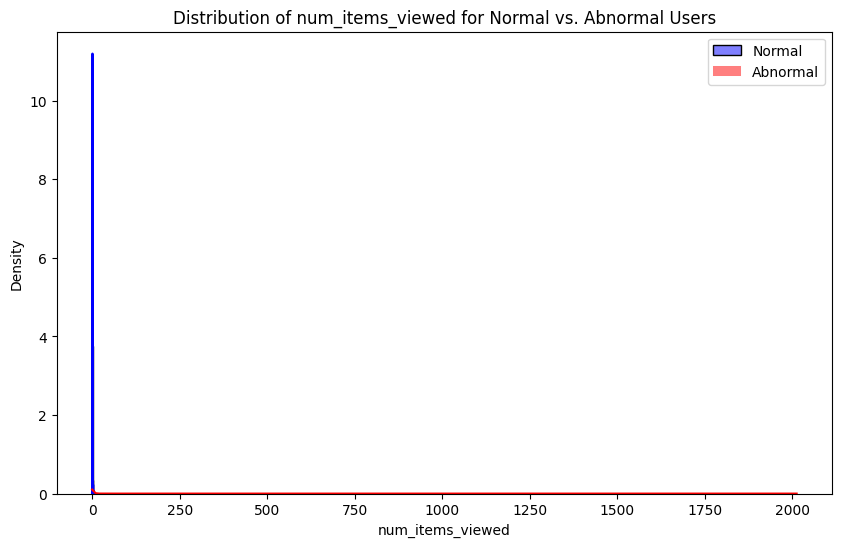

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


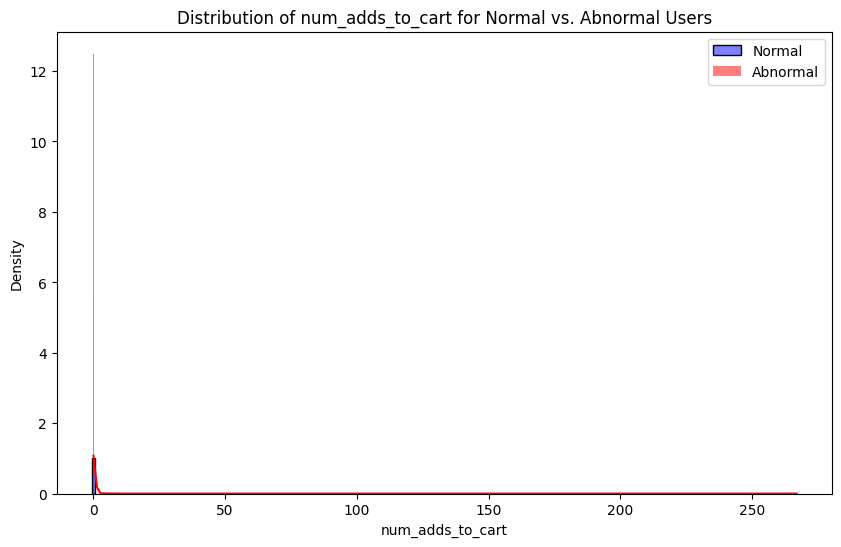

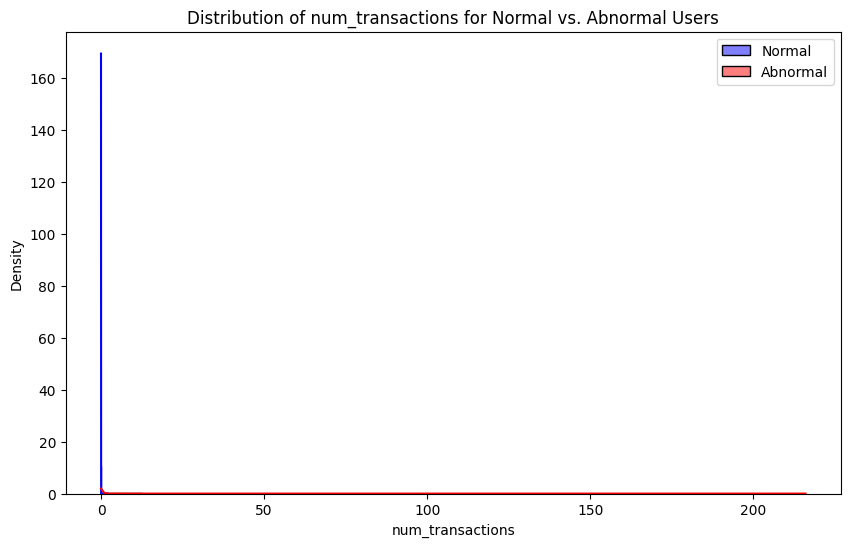

In [ ]:
# Separate normal and abnormal users
normal_users = user_features[user_features['anomaly_label'] == 1]

# Describe the features for abnormal and normal users to compare
print("\nDescription of features for abnormal users:")
display(abnormal_users.describe())

print("\nDescription of features for normal users:")
display(normal_users.describe())

# You can also visualize the distribution of key features for abnormal vs. normal users
# For example, using histograms or box plots
import matplotlib.pyplot as plt
import seaborn as sns

features_to_compare = ['num_events', 'time_spent', 'avg_time_between_events', 'num_items_viewed', 'num_adds_to_cart', 'num_transactions']

for feature in features_to_compare:
    plt.figure(figsize=(10, 6))
    sns.histplot(normal_users[feature], color='blue', label='Normal', kde=True, stat='density', common_norm=False)
    sns.histplot(abnormal_users[feature], color='red', label='Abnormal', kde=True, stat='density', common_norm=False)
    plt.title(f'Distribution of {feature} for Normal vs. Abnormal Users')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

## Abnormal User Removal

### Subtask:
Filter the original data to remove the identified abnormal users.

**Reasoning**:
Create a list of abnormal user IDs and filter the original `events_df` to exclude events from these users.

In [ ]:
# Get the list of abnormal user IDs
abnormal_user_ids = abnormal_users['visitorid'].tolist()

# Filter the original events_df to exclude abnormal users
events_df_filtered = events_df[~events_df['visitorid'].isin(abnormal_user_ids)]

print("\nShape of original events_df:", events_df.shape)
print("Shape of events_df after removing abnormal users:", events_df_filtered.shape)


Shape of original events_df: (2756101, 6)
Shape of events_df after removing abnormal users: (2087139, 6)


## Finish task

Summarize the approach and present the findings, including the number of abnormal users found and their characteristics.

**Summary**:

We have completed the task of identifying and removing abnormal users from the e-commerce data.

1.  **Data Loading**: Loaded the `events.csv` data.
2.  **Feature Engineering**: Created features to characterize user behavior, such as the number of events, time spent, and item interactions.
3.  **Abnormal User Detection Model**: Used an Isolation Forest model to detect anomalies based on the engineered features.
4.  **Model Training**: Trained the Isolation Forest model.
5.  **Abnormal User Identification**: Identified users classified as abnormal by the model.
6.  **Metric Creation**: Analyzed the characteristics of abnormal users by comparing their feature distributions to normal users. This serves as a way to evaluate the model's performance in the absence of true labels.
7.  **Abnormal User Removal**: Filtered the original `events_df` to remove events associated with the identified abnormal users.

We identified 54064 abnormal users. The comparison of feature distributions between normal and abnormal users provides insights into the behavioral patterns that the model flagged as anomalous. For example, abnormal users might have a significantly higher number of events, shorter time spent, or different patterns of item interactions compared to normal users.

The `events_df_filtered` DataFrame now contains the data with abnormal users removed, which can be used for further analysis or building recommendation systems.